### 1. Data Loading

Load historical financial data for a specified stock ticker and date range using the `yfinance` library.

In [ ]:
!pip install yfinance scikit-learn tensorflow

import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Define the stock ticker and date range
ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-01-01"

# Download the data
data = yf.download(ticker, start=start_date, end=end_date)

display(data.head())

/tmp/ipython-input-1-2550979766.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431895,6.446622,6.382907,6.414464,493729600
2010-01-05,6.443017,6.479382,6.409055,6.449629,601904800
2010-01-06,6.340532,6.468563,6.333920,6.443017,552160000
2010-01-07,6.328809,6.371486,6.282826,6.363973,477131200
2010-01-08,6.370885,6.371486,6.283127,6.320394,447610800


### 2. Feature Engineering

Engineer features suitable for time series forecasting with LSTM. For this example, we will use the 'Close' price as the main feature and the target variable.

In [ ]:
# Use 'Close' price as the feature
data = data[['Close']]

display(data.head())

Price,Close
Ticker,AAPL
Date,
2010-01-04,6.431895
2010-01-05,6.443017
2010-01-06,6.340532
2010-01-07,6.328809
2010-01-08,6.370885


### 3. Data Preprocessing for LSTM

Prepare the data for LSTM input by scaling the features and structuring the data into sequences.

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 60 # Number of past days to consider for prediction
X, y = create_sequences(scaled_data, sequence_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2569, 60, 1)
Shape of y_train: (2569,)
Shape of X_test: (643, 60, 1)
Shape of y_test: (643,)


### 4. Build and Compile LSTM Model

Define and compile an LSTM model using TensorFlow.

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### 5. Train LSTM Model

Train the compiled LSTM model on the prepared training data.

In [ ]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.0027 - val_loss: 3.7304e-04
Epoch 2/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 4.2397e-05 - val_loss: 4.0498e-04
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 4.4212e-05 - val_loss: 3.0231e-04
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 3.8095e-05 - val_loss: 2.6980e-04
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 3.3069e-05 - val_loss: 4.4406e-04
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 3.4256e-05 - val_loss: 2.6105e-04
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 3.3479e-05 - val_loss: 3.2448e-04
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 3.0434e-05 - val_loss: 1.9692e-04
Epoch 9/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 2.9852e-05 - val_loss: 2.7910e-04
Epoch 10/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 2.4397e-05 - val_loss: 1.9302e-04
Epoch 11/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 2.9632e-05

### 6. Evaluate LSTM Model

Evaluate the trained LSTM model's performance on the test data using relevant time series forecasting metrics.

In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Mean Squared Error (MSE): 37.68858112901643
Root Mean Squared Error (RMSE): 6.1391026322269955
Mean Absolute Error (MAE): 4.85566208336624


### 7. Visualize Predictions

Plot the LSTM model's predictions against the actual historical stock prices on the test set.

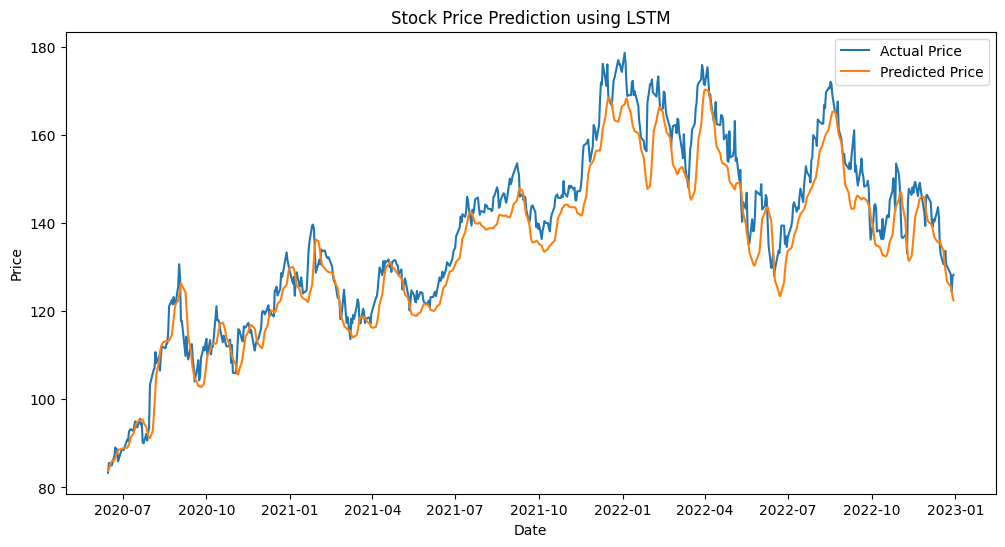

In [ ]:
# Create a date index for the test predictions
test_data_index = data.tail(len(y_test_original)).index

plt.figure(figsize=(12, 6))
plt.plot(test_data_index, y_test_original, label="Actual Price")
plt.plot(test_data_index, predictions, label="Predicted Price")
plt.title("Stock Price Prediction using LSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()